In [28]:
import numpy as np
from qiskit import *
import random
from qiskit.algorithms.optimizers import ADAM, AQGD, COBYLA, SPSA, TNC
from qiskit.opflow.gradients import Gradient, NaturalGradient, QFI
from qiskit.opflow import CircuitStateFn, StateFn, I, X, Y, Z, H, CX, Zero, One
from qiskit.circuit import QuantumCircuit, QuantumRegister, Parameter, ParameterVector, ParameterExpression

In [29]:
# Generate Primes as an array
primes = [2,3]#5,7,11,17,19,,31,37]
primes = primes[::-1]

In [30]:
# Generate Quantum Circuit single layer
def generate_circuit(params, assigned=True):
    cir = QuantumCircuit(len(primes))
    layers = int(len(params)/(4 * len(primes)))
    print(layers)
    thetas = [qiskit.circuit.Parameter(str(i)) for i in range(len(primes) * 4 * 1)]
#     thetas = free_params
    thetas_reshape = np.reshape(np.asarray(thetas),(layers, len(primes) * 4))
    params = np.reshape(np.asarray(params),(layers, len(primes) * 4))
#     cir.x(0)
#     cir.x(1)
#     cir.x(2)
#     cir.x(3)
#     cir.x(4)
#     cir.x(5)
#     cir.x(6)
#     cir.h(range(len(primes)))
    for m in range(layers):
        l = len(params[m])
        g = thetas_reshape[m][0:int(l/4)]
        b = thetas_reshape[m][int(l/4): int(2*l/4)]
        a = thetas_reshape[m][int(2*l/4): int(3*l/4)]
        t = thetas_reshape[m][int(3*l/4):l]

        for i in range(len(primes)):
            cir.ry(g[i], i)
        for j in range(len(primes)):
            if j != 0:
                cir.crz(b[j], j-1, j)
            else:
                cir.crz(b[j], len(primes)-1, j)
        for k in range(len(primes)):
            cir.ry(a[k], k)
        for o in range(len(primes)):
            cir.rx(t[o], o)
    if assigned == True:
        thetas_reshape = thetas_reshape.flatten()
        params = params.flatten()
        p_dict = {thetas[i] : params[i] for i in range(len(thetas))}
        cir.assign_parameters(p_dict, inplace=True)
    cir.measure_all()
    
    return cir, thetas

[2.8028261946175212, 1.0269370194887617, 0.874557825668265, 1.4946237704168244, 0.5188371722360797, 1.0908314929107943, 1.4398035511727447, 2.3574813550325966]
1
[Parameter(0), Parameter(1), Parameter(2), Parameter(3), Parameter(4), Parameter(5), Parameter(6), Parameter(7)]


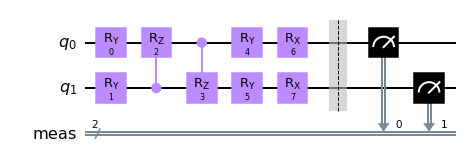

In [31]:
hyperparam = [random.uniform(0,np.pi) for _ in range(len(primes) * 4 * 1)]
print(hyperparam)
cir, free_params = generate_circuit(hyperparam, assigned=False)
print(free_params)

# Instantiate the Hamiltonian observable
# H = (Y ^ Y) @ ((I ^ H) @ CX @ (I ^ H)) @ (Y ^ Y) @ (X ^ X)

cir.draw('mpl')

In [34]:
# c = ((H ^ I) @ CX @ (H ^ I)) @ ((I ^ H) @ ((H ^ H) @ CX @ (H ^ H)) @ (I ^ H)) @ (Y ^ Y)
# c = (Y ^ Y) @ c
# c = (X ^ X) @ c
c = 6/4 * ((I ^ I) - (Z ^ I) - (I ^ Z) + (Z ^ Z))
print(c)

1.5 * II
- 1.5 * ZI
- 1.5 * IZ
+ 1.5 * ZZ


In [35]:
layers = 1
grad = "param_shift"
gradient_object = Gradient(grad_method=grad)

cir.remove_final_measurements()
# Combine the Hamiltonian observable and the state
op = ~StateFn(c) @ CircuitStateFn(primitive=cir, coeff=1.)
# print(op)
grad_object = gradient_object.convert(operator=op, params=free_params)
print(grad_object)
value_dict = {free_params[i]: hyperparam[i] for i in range(len(free_params))}
# print(value_dict)
x = grad_object.assign_parameters(value_dict)
print(x.eval())
# analytical_gradients = np.array(x)# Change this part
#             loss_gradients.append(analytical_gradients)

ListOp([
  SummedOp([
    0.75 * ComposedOp([
      OperatorMeasurement(II),
      CircuitStateFn(
           ┌─────────────────────────┐┌────────┐┌───┐┌───────────┐┌───┐          »
      q_0: ┤ RY(0 + 1.5707963267949) ├┤ P(2/2) ├┤ X ├┤ P(-0.5*2) ├┤ X ├──────────»
           └────────┬───────┬────────┘└────────┘└─┬─┘└───────────┘└─┬─┘┌────────┐»
      q_1: ─────────┤ RY(1) ├─────────────────────■─────────────────■──┤ P(3/2) ├»
                    └───────┘                                          └────────┘»
      «                            ┌───────┐┌───────┐
      «q_0: ──■─────────────────■──┤ RY(4) ├┤ RX(6) ├
      «     ┌─┴─┐┌───────────┐┌─┴─┐├───────┤├───────┤
      «q_1: ┤ X ├┤ P(-0.5*3) ├┤ X ├┤ RY(5) ├┤ RX(7) ├
      «     └───┘└───────────┘└───┘└───────┘└───────┘
      )
    ]),
    -0.75 * ComposedOp([
      OperatorMeasurement(II),
      CircuitStateFn(
           ┌─────────────────────────┐┌────────┐┌───┐┌───────────┐┌───┐          »
      q_0: ┤ RY(0 - 1.5707963267949) ├┤

[(-1.1975445895079346+0j), (-1.097345312227154+0j), (0.7803220463823726+0j), (1.34014318723425+0j), (-0.07227380701883201+0j), (-0.5982172104118958+0j), (-0.9055151062819217+0j), (1.6037271700785867+0j)]


In [ ]:
# Instantiate the quantum state
a = Parameter('a')
b = Parameter('b')
c = Parameter('c')
d = Parameter('d')
e = Parameter('e')
f = Parameter('f')
q = QuantumRegister(2)
qc = QuantumCircuit(q)
qc.h(q)
qc.ry(a, q[0])
qc.ry(b, q[1])
qc.ry(c, q[0])
qc.ry(d, q[1])
qc.rx(e, q[0])
qc.rx(f, q[1])

# Instantiate the Hamiltonian observable
H = (Y ^ Y) @ (Y ^ Y) @ (X ^ X)


# Combine the Hamiltonian observable and the state
op = ~StateFn(H) @ CircuitStateFn(primitive=qc, coeff=1.)
print(op)

# Print the operator corresponding to the expectation value
# print(op)
qc.draw('mpl')

In [ ]:
free_params = [a,b,c,d,e,f]

grad = "param_shift"
gradient_object = Gradient(grad_method=grad)

grad_object = gradient_object.convert(operator=op, params=free_params)

print(grad_object)

In [ ]:
# Define the values to be assigned to the parameters
value_dict = {a: np.pi / 4, b: np.pi, c: np.pi, d: np.pi, e: np.pi, f: np.pi}
print(value_dict)

x = grad_object.assign_parameters(value_dict).eval()

print(x)